# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem


In [115]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA


In [2]:
# Configuration

config = {
    'path1': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_1_10.pth",
    'modelname1': 'VAE1',
    'path2': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_2_10.pth",
    'modelname2': 'VAE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE

In [10]:
# get working directory
import os
# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

shit at random
# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from VAE.model_def import VAE
DEVICE = torch.device('mps')

# Initialize the models
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)

# Load pretrained weights for model1
model.load_state_dict(torch.load(config['path1']))

# Initialize the model 2
model2 = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)
# Load pretrained weights for model2
model2.load_state_dict(torch.load(config['path2']))




<All keys matched successfully>

## Sampling 
We sample images from the train set and encode those for each model 

In [105]:
# Sample Size 
m = 100

# Sample images from train set 
images, _ = next(iter(data_loader.train_loader))

images = images[0:m]

# Sample indices from the train set
indices = np.random.choice(images.shape[0], m, replace=False)

#
z1 = model.getLatenSpace(images.to(DEVICE))
z2 = model2.getLatenSpace(images.to(DEVICE))

print(z1.shape)
print(z2.shape)
# Detach from GPU
z1 = z1.detach().cpu().numpy()
z2 = z2.detach().cpu().numpy()  

torch.Size([100, 32])
torch.Size([100, 32])


# Calulate optimal matrix 

15.26265214099198


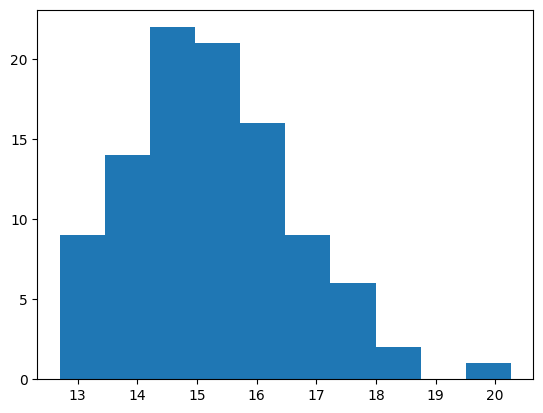

In [123]:

# Regularization 
lamda = 0.0001


# Get the dimensions of the latent space
d = z1.shape[1]


# Initalize the matrices
M = np.zeros((d, d))
L = np.zeros((d, d))

# Compute the matrices
for i in range(d):
    M = M + np.outer(z1[i], z2[i])
    L = L + np.outer(z1[i], z2[i])

# COmpute the optimal regularized matrix
A = L @ np.linalg.inv(M + lamda * np.eye(d))

# Compute distance
np.linalg.norm(A@z1[i] - z2[i])
distance = np.zeros(m)
for i in range(m):
    distance[i] = np.linalg.norm(A@z1[i] - z2[i])

# Plot the distance
plt.hist(distance)

# Overall Loss 

overall_loss = np.mean(distance)
print(overall_loss)







(60000, 32)
(60000,)


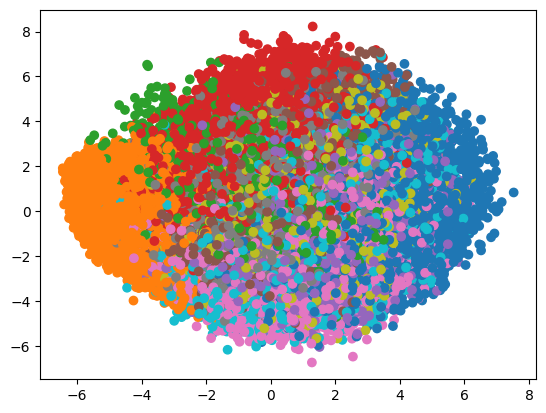

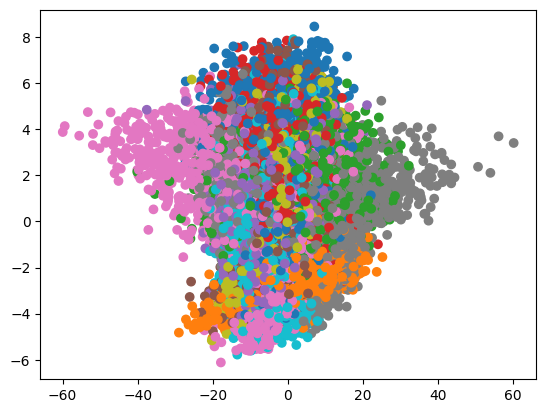

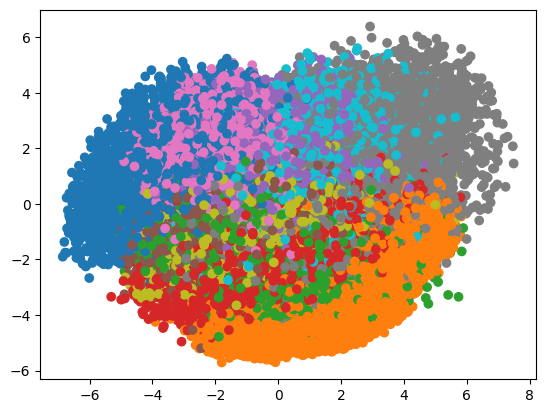

In [118]:

# Latent Space
latent_spaces = []
latent_spaces2 = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in data_loader.train_loader:
    images = images.to(DEVICE)
    images = images.view(images.size(0), -1)
    latent_space = model.getLatenSpace(images)
    latent_space2 = model2.getLatenSpace(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    latent_spaces2.append(latent_space2.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
latent_space2 = np.concatenate(latent_spaces2, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)



# Plot latent space via PCA
pca = PCA(n_components=2)


latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Transform the latent space
latent_space_transformed = np.dot(latent_space, A.T)
# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_transformed)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)


# Plot the second latent space
latent_space_pca2 = pca.fit_transform(latent_space2)

pca_second = PCA(n_components=2)
plot_second = plt.scatter(latent_space_pca2[:, 0], latent_space_pca2[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot_second)
